# Introduction

Nowadays(2024, India), cars under 20L are offering ADAS with good sense over lanes, traffic and traffic signs. Traffic signs detection is one of the main part in automated vehicle control. This is a CNN project, MobileNetV2 is used. The data set is downloaded from kaggle ("Indian Traffic Signs Prediction(85 classes)") 

### 1. Importing Dataset

In [1]:
%config IPCompleter.greedy = True

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [3]:
#API Token has to be imported
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
# Importing a dataset from kaggle
!kaggle datasets download -d sarangdilipjodh/indian-traffic-signs-prediction85-classes

Dataset URL: https://www.kaggle.com/datasets/sarangdilipjodh/indian-traffic-signs-prediction85-classes
License(s): CC0-1.0
100% 1.13G/1.13G [00:50<00:00, 23.3MB/s]
100% 1.13G/1.13G [00:50<00:00, 24.0MB/s]


In [5]:
# The dataset downloaded is zipped. We need to unzip to proceed further
import zipfile
zip = zipfile.ZipFile('/content/indian-traffic-signs-prediction85-classes.zip')
zip.extractall('/content')
zip.close()

### 2. Relevant Libraries

In [6]:
# Importing Relevant Libraries
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf

### 3. Importing and creating test, train dataset

In [7]:
# Since we are using MobileNetV2, it's default input layer size is (224, 224). We are keeping its same.
Image_size = [224, 224]

In [8]:
train_path = '/content/traffic_sign_classification_dataset/train'
test_path = '/content/traffic_sign_classification_dataset/test'

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   zoom_range = 0.2,
                                   rotation_range = 10,
                                   shear_range = 0.2)

test_datagen = ImageDataGenerator(rescale = 1.0/255)

In [10]:
train_data = train_datagen.flow_from_directory(train_path, target_size= (Image_size[1], Image_size[0]),
                                               batch_size = 32, class_mode = 'categorical')

Found 4438 images belonging to 85 classes.


In [11]:
test_data = test_datagen.flow_from_directory(test_path, target_size= (Image_size[1], Image_size[0]),
                                               batch_size = 32, class_mode = 'categorical')

Found 1288 images belonging to 85 classes.


In [12]:
# The output of class_indices of train_data will be in dictionary (keys - values). We are taking out the keys and forming a list with it.
data_classes = list(train_data.class_indices.keys())

In [13]:
data_classes

['ALL_MOTOR_VEHICLE_PROHIBITED',
 'AXLE_LOAD_LIMIT',
 'BARRIER_AHEAD',
 'BULLOCK_AND_HANDCART_PROHIBITED',
 'BULLOCK_PROHIBITED',
 'CATTLE',
 'COMPULSARY_AHEAD',
 'COMPULSARY_AHEAD_OR_TURN_LEFT',
 'COMPULSARY_AHEAD_OR_TURN_RIGHT',
 'COMPULSARY_CYCLE_TRACK',
 'COMPULSARY_KEEP_LEFT',
 'COMPULSARY_KEEP_RIGHT',
 'COMPULSARY_MINIMUM_SPEED',
 'COMPULSARY_SOUND_HORN',
 'COMPULSARY_TURN_LEFT',
 'COMPULSARY_TURN_LEFT_AHEAD',
 'COMPULSARY_TURN_RIGHT',
 'COMPULSARY_TURN_RIGHT_AHEAD',
 'CROSS_ROAD',
 'CYCLE_CROSSING',
 'CYCLE_PROHIBITED',
 'DANGEROUS_DIP',
 'DIRECTION',
 'FALLING_ROCKS',
 'FERRY',
 'GAP_IN_MEDIAN',
 'GIVE_WAY',
 'GUARDED_LEVEL_CROSSING',
 'HANDCART_PROHIBITED',
 'HEIGHT_LIMIT',
 'HORN_PROHIBITED',
 'HUMP_OR_ROUGH_ROAD',
 'LEFT_HAIR_PIN_BEND',
 'LEFT_HAND_CURVE',
 'LEFT_REVERSE_BEND',
 'LEFT_TURN_PROHIBITED',
 'LENGTH_LIMIT',
 'LOAD_LIMIT',
 'LOOSE_GRAVEL',
 'MEN_AT_WORK',
 'NARROW_BRIDGE',
 'NARROW_ROAD_AHEAD',
 'NO_ENTRY',
 'NO_PARKING',
 'NO_STOPPING_OR_STANDING',
 'OVERTAKING_P

### 4. Model Creation

In [14]:
# Creating MobileNetV2 model. Parameters are explained below.
# IMAGE_SIZE = input image size, [3] indicates it's RGB channel
# weights = 'imagenet'. It means we are taking weights as per standard MobileNetV2.
# include_top = False. Input and output layers are given by us.
base_model = MobileNetV2(input_shape = Image_size + [3], weights = 'imagenet', include_top= False)

9406464/9406464 [==============================] - 1s 0us/step


In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [16]:
# don't train existing weights. we are just using the trained weights
for layer in base_model.layers:
    layer.trainable = False

In [17]:
# Adding a flattening layer
x = Flatten()(base_model.output)

In [18]:
# The number of nodes in the output layer is length of classes. activation layer in output layer is softmax
prediction = Dense(len(data_classes), activation = 'softmax')(x)

In [19]:
# create a model object
model = Model(inputs = base_model.input, outputs = prediction)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [22]:
#after few runs of epochs accuracy wil not improve. we need to stop the training.
#Inorder to stop the training, we need to motinor the accuracy values. we'll do it as below
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor = 'val_loss',
min_delta = 0.001,
patience = 20,
verbose = 1,
mode = 'auto',
baseline=None,
restore_best_weights = False
)

In [23]:
r = model.fit(train_data, validation_data= test_data, epochs=50, callbacks= early_stopping)

Epoch 1/50
139/139 [==============================] - 110s 741ms/step - loss: 11.2018 - accuracy: 0.5692 - val_loss: 9.1381 - val_accuracy: 0.6693
Epoch 2/50
139/139 [==============================] - 100s 718ms/step - loss: 4.1416 - accuracy: 0.8076 - val_loss: 10.7436 - val_accuracy: 0.6933
Epoch 3/50
139/139 [==============================] - 108s 775ms/step - loss: 3.5946 - accuracy: 0.8457 - val_loss: 10.0662 - val_accuracy: 0.7151
Epoch 4/50
139/139 [==============================] - 99s 713ms/step - loss: 2.9120 - accuracy: 0.8743 - val_loss: 9.2647 - val_accuracy: 0.7585
Epoch 5/50
139/139 [==============================] - 98s 704ms/step - loss: 2.5245 - accuracy: 0.9042 - val_loss: 9.3731 - val_accuracy: 0.7795
Epoch 6/50
139/139 [==============================] - 100s 723ms/step - loss: 2.3548 - accuracy: 0.9069 - val_loss: 12.5421 - val_accuracy: 0.7585
Epoch 7/50
139/139 [==============================] - 103s 738ms/step - loss: 1.9809 - accuracy: 0.9250 - val_loss: 10.754

### 5. Model Evaluation

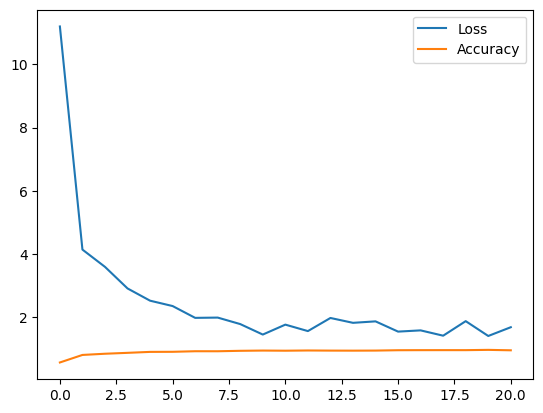

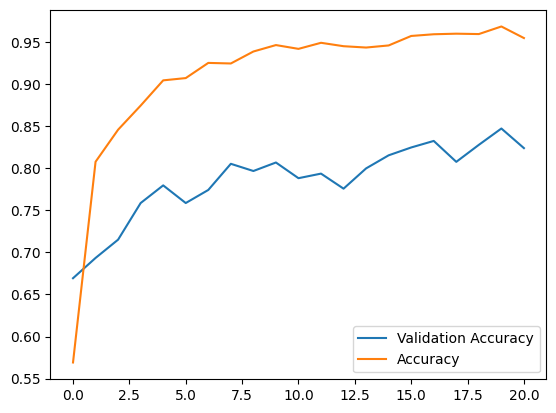

In [28]:
# Plotting accuracy graphs
plt.plot(r.history['loss'], label = 'Loss')
plt.plot(r.history['accuracy'], label = 'Accuracy')
plt.legend()
plt.show()

plt.plot(r.history['val_accuracy'], label = 'Validation Accuracy')
plt.plot(r.history['accuracy'], label = 'Accuracy')
plt.legend()
plt.show()


In [ ]:
# Training accuracy of this model is around 95%. 
# Validation accuracy is around 85%

### 6. Model Prediction

In [75]:
#Adding path for image prediction
predict_path = '/content/predict1.jpg'

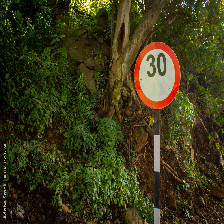

In [76]:
#Target image size should be same as that of model's input image size
predict_img = image.load_img(predict_path, target_size = (Image_size[1], Image_size[0]))
predict_img

In [77]:
#Image data should be converted into array
predict_img_arr = image.img_to_array(predict_img)

In [78]:
predict_img_arr

array([[[  8.,  30.,   9.],
        [ 10.,  16.,   4.],
        [ 32.,  42.,  17.],
        ...,
        [157., 173.,  12.],
        [133., 119.,  31.],
        [175., 196., 129.]],

       [[ 15.,  34.,   4.],
        [  6.,  19.,   1.],
        [  6.,  17.,   3.],
        ...,
        [ 80.,  88.,  29.],
        [121., 140.,  14.],
        [131., 124.,  52.]],

       [[ 18.,  31.,   1.],
        [ 11.,  37.,   0.],
        [ 22.,  36.,   0.],
        ...,
        [ 78.,  92.,  30.],
        [215., 210.,   4.],
        [171., 167.,  44.]],

       ...,

       [[ 14.,   7.,   0.],
        [ 28.,  19.,   4.],
        [ 14.,   5.,   0.],
        ...,
        [ 65.,  39.,  16.],
        [ 39.,  22.,   2.],
        [ 86.,  54.,  31.]],

       [[ 24.,  11.,   5.],
        [ 31.,  18.,   9.],
        [ 15.,   8.,   2.],
        ...,
        [ 60.,  52.,  13.],
        [ 42.,  20.,   7.],
        [ 50.,  32.,  10.]],

       [[ 26.,  16.,   7.],
        [ 33.,  19.,  10.],
        [ 29.,  

In [79]:
#Converting to tensor
predict_img_arr_expdim = tf.expand_dims(predict_img_arr, 0)

In [80]:
predict_img_arr_expdim

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[  8.,  30.,   9.],
         [ 10.,  16.,   4.],
         [ 32.,  42.,  17.],
         ...,
         [157., 173.,  12.],
         [133., 119.,  31.],
         [175., 196., 129.]],

        [[ 15.,  34.,   4.],
         [  6.,  19.,   1.],
         [  6.,  17.,   3.],
         ...,
         [ 80.,  88.,  29.],
         [121., 140.,  14.],
         [131., 124.,  52.]],

        [[ 18.,  31.,   1.],
         [ 11.,  37.,   0.],
         [ 22.,  36.,   0.],
         ...,
         [ 78.,  92.,  30.],
         [215., 210.,   4.],
         [171., 167.,  44.]],

        ...,

        [[ 14.,   7.,   0.],
         [ 28.,  19.,   4.],
         [ 14.,   5.,   0.],
         ...,
         [ 65.,  39.,  16.],
         [ 39.,  22.,   2.],
         [ 86.,  54.,  31.]],

        [[ 24.,  11.,   5.],
         [ 31.,  18.,   9.],
         [ 15.,   8.,   2.],
         ...,
         [ 60.,  52.,  13.],
         [ 42.,  20.,   7.],
         

In [81]:
predict_model = model.predict(predict_img_arr_expdim)

1/1 [==============================] - 0s 20ms/step


In [82]:
#Checking the score using softmax function (can be used for models which has softmax activation in output layer)
score = tf.nn.softmax(predict_model)

In [83]:
#Using numpy taking the max score from the array and checking the index of the class
predict_sign = (data_classes[np.argmax(score)])

In [84]:
predict_sign

'SPEED_LIMIT_30'